In [1]:
import torch
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import animation
import scienceplots
plt.style.use(['science', 'notebook'])
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Define number of particles and get random positions (between 0 and 1) for each particle

In [2]:
n_particles = 16
r = torch.rand((2,n_particles)).to(device)

In [3]:
n_particles = 16
r = torch.rand((2,n_particles)).to(device)
# Color particles the start on either side
ixr = r[0]>0.5 #right
ixl = r[0]<=0.5 #left

Give IDs to each particle (this will come in handy later)

In [4]:
ids = torch.arange(n_particles)

Plot initial configuration of particles

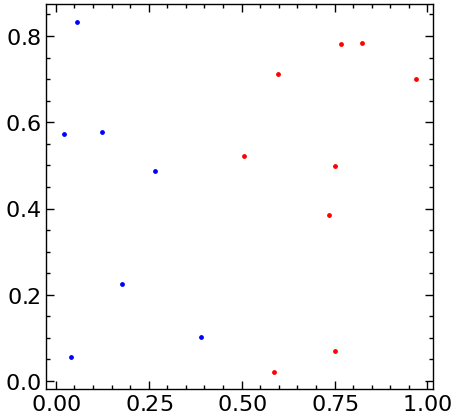

In [5]:
plt.figure(figsize=(5,5))
plt.scatter(r[0][ixr].cpu(),r[1][ixr].cpu(), color='r', s=6)
plt.scatter(r[0][ixl].cpu(),r[1][ixl].cpu(), color='b', s=6)

Obtain the initial velocities in the gas. We'll make the particles starting on the RHS move to the left at 500m/s and on the vice versa.

* **Note**: We're using the assumption that particles in a gas move at approximately 500m/s, thanks google.

In [6]:
v = torch.zeros((2,n_particles)).to(device)
v[0][ixr] = -500
v[0][ixl] = 500

To run this simulation, we need to determine when two particles collide, and what the resulting final velocities will be.

# Part 1: Distance Between all Pairs

* To determine if two particles collide, we need to find the distance between **all pairs** of particles. If the distance is less than 2 times the radius of each particle, they collide. If there are $n$ particles, there are $n(n-1)/2$ pairs (combinatorics). To make this easier, we'll get pairs of particle IDs.

In [7]:
ids_pairs = torch.combinations(ids,2).to(device)
#ids_pairs

We can obtain distances between particles in a similar fashion

* First get the pairs of x-positions of all particles (**NOTE: THIS HAS BEEN UPDATED SINCE THE YOUTUBE VIDEO AND IS MUCH MORE EFFICIENT. THANK YOU TO @swni ON REDDIT FOR THE SUGGESTION**)

In [8]:
x_pairs = torch.stack([r[0][ids_pairs[:,0]], r[0][ids_pairs[:,1]]]).T
x_pairs

tensor([[0.7684, 0.0401],
        [0.7684, 0.3898],
        [0.7684, 0.0207],
        [0.7684, 0.9690],
        [0.7684, 0.5064],
        [0.7684, 0.7347],
        [0.7684, 0.5979],
        [0.7684, 0.7508],
        [0.7684, 0.5885],
        [0.7684, 0.2667],
        [0.7684, 0.7507],
        [0.7684, 0.1785],
        [0.7684, 0.8240],
        [0.7684, 0.1251],
        [0.7684, 0.0577],
        [0.0401, 0.3898],
        [0.0401, 0.0207],
        [0.0401, 0.9690],
        [0.0401, 0.5064],
        [0.0401, 0.7347],
        [0.0401, 0.5979],
        [0.0401, 0.7508],
        [0.0401, 0.5885],
        [0.0401, 0.2667],
        [0.0401, 0.7507],
        [0.0401, 0.1785],
        [0.0401, 0.8240],
        [0.0401, 0.1251],
        [0.0401, 0.0577],
        [0.3898, 0.0207],
        [0.3898, 0.9690],
        [0.3898, 0.5064],
        [0.3898, 0.7347],
        [0.3898, 0.5979],
        [0.3898, 0.7508],
        [0.3898, 0.5885],
        [0.3898, 0.2667],
        [0.3898, 0.7507],
        [0.3

* Then take the difference to get $\Delta x_{ij}$ of all pairs

In [9]:
dx_pairs = torch.diff(x_pairs, axis=1).ravel()
dx_pairs

tensor([-7.2827e-01, -3.7858e-01, -7.4769e-01,  2.0058e-01, -2.6199e-01,
        -3.3640e-02, -1.7044e-01, -1.7614e-02, -1.7993e-01, -5.0168e-01,
        -1.7670e-02, -5.8988e-01,  5.5569e-02, -6.4330e-01, -7.1066e-01,
         3.4969e-01, -1.9415e-02,  9.2886e-01,  4.6629e-01,  6.9463e-01,
         5.5783e-01,  7.1066e-01,  5.4835e-01,  2.2659e-01,  7.1060e-01,
         1.3840e-01,  7.8384e-01,  8.4972e-02,  1.7615e-02, -3.6910e-01,
         5.7917e-01,  1.1660e-01,  3.4494e-01,  2.0814e-01,  3.6097e-01,
         1.9866e-01, -1.2310e-01,  3.6091e-01, -2.1129e-01,  4.3415e-01,
        -2.6472e-01, -3.3207e-01,  9.4827e-01,  4.8570e-01,  7.1405e-01,
         5.7725e-01,  7.3007e-01,  5.6776e-01,  2.4600e-01,  7.3002e-01,
         1.5781e-01,  8.0326e-01,  1.0439e-01,  3.7030e-02, -4.6257e-01,
        -2.3422e-01, -3.7102e-01, -2.1820e-01, -3.8051e-01, -7.0227e-01,
        -2.1825e-01, -7.9046e-01, -1.4502e-01, -8.4389e-01, -9.1124e-01,
         2.2835e-01,  9.1546e-02,  2.4437e-01,  8.2

The total distance is just $d_{ij}= \sqrt{\Delta x_{ij}^2 + \Delta y_{ij}^2}$. Since there are $n(n-1)/2$ pairs, there will be $n(n-1)/2$ different values of $d_{ij}$.

In [10]:
x_pairs = torch.stack([r[0][ids_pairs[:,0]], r[0][ids_pairs[:,1]]]).T
y_pairs = torch.stack([r[1][ids_pairs[:,0]], r[1][ids_pairs[:,1]]]).T
dx_pairs = torch.diff(x_pairs, axis=1).ravel()
dy_pairs = torch.diff(y_pairs, axis=1).ravel()
d_pairs = torch.sqrt(dx_pairs**2 + dy_pairs**2)
d_pairs

tensor([1.0267, 0.7778, 0.7760, 0.2159, 0.3675, 0.3974, 0.1833, 0.2823, 0.7796,
        0.5812, 0.7102, 0.8095, 0.0557, 0.6746, 0.7126, 0.3525, 0.5163, 1.1301,
        0.6592, 0.7681, 0.8613, 0.8368, 0.5495, 0.4862, 0.7107, 0.2187, 1.0690,
        0.5273, 0.7768, 0.5989, 0.8336, 0.4376, 0.4465, 0.6464, 0.5371, 0.2138,
        0.4051, 0.3622, 0.2455, 0.8090, 0.5449, 0.8041, 0.9569, 0.4883, 0.7384,
        0.5941, 0.7338, 0.7911, 0.2605, 0.8861, 0.3808, 0.8305, 0.1045, 0.2633,
        0.4956, 0.3934, 0.3712, 0.2973, 0.7781, 0.7340, 0.6668, 0.9219, 0.1671,
        0.8528, 0.9209, 0.2670, 0.2111, 0.2456, 0.5076, 0.2424, 0.5141, 0.4422,
        0.4110, 0.3852, 0.5457, 0.3558, 0.1153, 0.3911, 0.4791, 0.3145, 0.5784,
        0.4090, 0.6394, 0.8123, 0.2632, 0.6912, 0.4010, 0.6605, 0.6427, 0.2368,
        0.4920, 0.5535, 0.5037, 0.4842, 0.4282, 0.6339, 0.2942, 0.6306, 0.7696,
        0.5655, 0.1694, 0.4580, 0.7974, 0.7233, 0.9696, 0.6385, 0.2753, 0.6313,
        0.1680, 0.4046, 0.5930, 0.7170, 

# Part 2: Velocities of a Collision

So at each iteration of the simulation, we will evaluate `d_pairs`, and if any of the distances between particles is less than $2r$, then a collision occurs. What is the final velocity of each of the two spheres? In an elastic collision (conservation of energy + momentum + angular momentum), one can show

$$\vec{v}_1^{\text{new}} = \vec{v}_1 - \frac{(\vec{v}_1 - \vec{v}_2) \cdot (\vec{r}_1 - \vec{r}_2)}{|\vec{r}_1 - \vec{r}_2|^2} (\vec{r}_1 - \vec{r}_2)$$
$$\vec{v}_2^{\text{new}} = \vec{v}_2 - \frac{(\vec{v}_2 - \vec{v}_1) \cdot (\vec{r}_2 - \vec{r}_1)}{|\vec{r}_1 - \vec{r}_2|^2} (\vec{r}_2 - \vec{r}_1)$$

In [11]:
radius = 0.06
ids_pairs_collide = ids_pairs[d_pairs < 2*radius]
ids_pairs_collide

tensor([[ 0, 13],
        [ 3, 14],
        [ 6,  8]])

We will call all the particles in the left column "1" and the right column "2"

In [12]:
v1 = v[:,ids_pairs_collide[:,0]]
v2 = v[:,ids_pairs_collide[:,1]]
r1 = r[:,ids_pairs_collide[:,0]]
r2 = r[:,ids_pairs_collide[:,1]]

Then we can compute the new velocity:

In [13]:
v1new = v1 - torch.sum((v1-v2)*(r1-r2), axis=0)/torch.sum((r1-r2)**2, axis=0) * (r1-r2)
v2new = v2 - torch.sum((v1-v2)*(r1-r2), axis=0)/torch.sum((r2-r1)**2, axis=0) * (r2-r1)

# Part 3: Functions to Run the Simulation

Here we define some functions that will help make running the simulation easier.

In [14]:
def get_deltad2_pairs(r, ids_pairs):
    dx = torch.diff(torch.stack([r[0][ids_pairs[:,0]], r[0][ids_pairs[:,1]]]).T).squeeze()
    dy = torch.diff(torch.stack([r[1][ids_pairs[:,0]], r[1][ids_pairs[:,1]]]).T).squeeze()
    return dx**2 + dy**2

def compute_new_v(v1, v2, r1, r2):
    v1new = v1 - torch.sum((v1-v2)*(r1-r2), axis=0)/torch.sum((r1-r2)**2, axis=0) * (r1-r2)
    v2new = v2 - torch.sum((v1-v2)*(r1-r2), axis=0)/torch.sum((r2-r1)**2, axis=0) * (r2-r1)
    return v1new, v2new

def motion(r, v, id_pairs, ts, dt, d_cutoff):
    rs = torch.zeros((ts, r.shape[0], r.shape[1])).to(device)
    vs = torch.zeros((ts, v.shape[0], v.shape[1])).to(device)
    # Initial State
    rs[0] = r
    vs[0] = v
    for i in range(1,ts):
        ic = id_pairs[get_deltad2_pairs(r, ids_pairs) < d_cutoff**2]
        v[:,ic[:,0]], v[:,ic[:,1]] = compute_new_v(v[:,ic[:,0]], v[:,ic[:,1]], r[:,ic[:,0]], r[:,ic[:,1]])
        
        v[0,r[0]>1] = -torch.abs(v[0,r[0]>1])
        v[0,r[0]<0] = torch.abs(v[0,r[0]<0])
        v[1,r[1]>1] = -torch.abs(v[1,r[1]>1])
        v[1,r[1]<0] = torch.abs(v[1,r[1]<0])
        
        r = r + v*dt
        rs[i] = r
        vs[i] = v
    return rs, vs

Set the radius and find the position of all particles as a function of time (3D array `rs` where each axis is $(t,x,y)$).

In [15]:
radius = 0.03
rs, vs = motion(r, v, ids_pairs, ts=1000, dt=0.000008, d_cutoff=2*radius)

Plot red and blue circles, making sure each is the correct size.

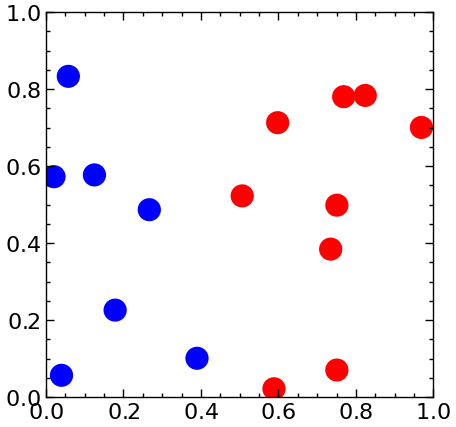

In [16]:
fig, ax = plt.subplots(1,1,figsize=(5,5))
xred, yred = rs[0][0][ixr], rs[0][1][ixr]
xblue, yblue = rs[0][0][ixl],rs[0][1][ixl]
circles_red = [plt.Circle((xi, yi), radius=radius, linewidth=0) for xi,yi in zip(xred,yred)]
circles_blue = [plt.Circle((xi, yi), radius=radius, linewidth=0) for xi,yi in zip(xblue,yblue)]
cred = matplotlib.collections.PatchCollection(circles_red, facecolors='red')
cblue = matplotlib.collections.PatchCollection(circles_blue, facecolors='blue')
ax.add_collection(cred)
ax.add_collection(cblue)
ax.set_xlim(0,1)
ax.set_ylim(0,1)
plt.show()

Make initial animation of the simulation

FileNotFoundError: [WinError 2] The system cannot find the file specified

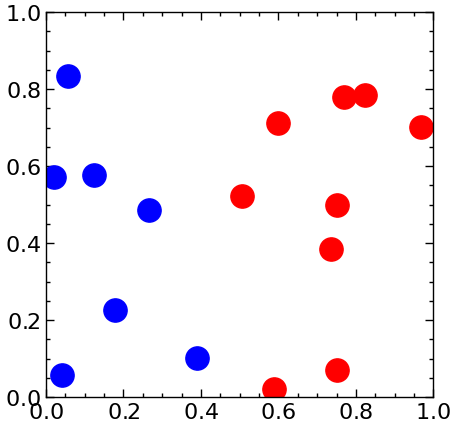

In [27]:
fig, ax = plt.subplots(1,1,figsize=(5,5))
ax.clear()
vmin = 0
vmax = 1
ax.set_xlim(0,1)
ax.set_ylim(0,1)
markersize = 2 * radius * ax.get_window_extent().width  / (vmax-vmin) * 72./fig.dpi
red, = ax.plot([], [], 'o', color='red', markersize=markersize)
blue, = ax.plot([], [], 'o', color='blue', markersize=markersize)

def animate(i):
    xred, yred = rs[i][0][ixr].cpu(), rs[i][1][ixr].cpu()
    xblue, yblue = rs[i][0][ixl].cpu(),rs[i][1][ixl].cpu()
    red.set_data(xred, yred)
    blue.set_data(xblue, yblue)
    return red, blue

writer = animation.FFMpegWriter(fps=30)
ani = animation.FuncAnimation(fig, animate, frames=500, interval=50, blit=True)
ani.save('C:\\Users\\benja\\OneDrive\\Documents\\GitHub\\Summer23\\Aero-303\\gpu-simulation\\ani3.mp4',writer=writer,dpi=100)

Now that we're sure that it works, lets make a simulation containing many more particles

In [ ]:
n_particles = 5000
r = torch.rand((2,n_particles)).to(device)
ixr = r[0]>0.5 
ixl = r[0]<=0.5 
ids = torch.arange(n_particles)
ids_pairs = torch.combinations(ids,2).to(device)
v = torch.zeros((2,n_particles)).to(device)
v[0][ixr] = -500
v[0][ixl] = 500
radius = 0.0005
rs, vs = motion(r, v, ids_pairs, ts=1000, dt=0.000008, d_cutoff=2*radius)

Let's look at the final velocity distribution of the particles and compare it to Maxwell-Boltzmann in 2 Dimensions:

* $kT = KE_{avg} = \frac{1}{2}m\bar{v^2} \implies \boxed{\frac{m}{kT} = \frac{2}{\bar{v^2}}}$
* $\boxed{f(v) = \frac{m}{kT} v \exp\left(-\frac{m}{kT}\frac{v^2}{2} \right)}$

In [ ]:
v = np.linspace(0, 2000, 1000)
a = 2/500**2
fv = a*v*np.exp(-a*v**2 / 2)

Plot the final histogram next to this curve:

In [ ]:
bins = np.linspace(0,1500,50)
plt.figure()
plt.hist(torch.sqrt(torch.sum(vs[-1]**2, axis=0)).cpu(), bins=bins, density=True)
plt.plot(v,fv)
plt.xlabel('Velocity [m/s]')
plt.ylabel('# Particles')

Finally, we can make an animation of the particles moving around and the histogram at the same time

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(20,10))
axes[0].clear()
vmin = 0
vmax = 1
axes[0].set_xlim(0,1)
axes[0].set_ylim(0,1)
markersize = 2 * radius * axes[0].get_window_extent().width  / (vmax-vmin) * 72./fig.dpi
red, = axes[0].plot([], [], 'o', color='red', markersize=markersize)
blue, = axes[0].plot([], [], 'o', color='blue', markersize=markersize)
n, bins, patches = axes[1].hist(torch.sqrt(torch.sum(vs[0]**2, axis=0)).cpu(), bins=bins, density=True)
axes[1].plot(v,fv)
axes[1].set_ylim(top=0.003)

def animate(i):
    xred, yred = rs[i][0][ixr].cpu(), rs[i][1][ixr].cpu()
    xblue, yblue = rs[i][0][ixl].cpu(),rs[i][1][ixl].cpu()
    red.set_data(xred, yred)
    blue.set_data(xblue, yblue)
    hist, _ = np.histogram(torch.sqrt(torch.sum(vs[i]**2, axis=0)).cpu(), bins=bins, density=True)
    for i, patch in enumerate(patches):
        patch.set_height(hist[i])
    return red, blue

writer = animation.FFMpegWriter(fps=30)
ani = animation.FuncAnimation(fig, animate, frames=500, interval=50, blit=True)
ani.save('ani_gpu_10000.mp4',writer=writer,dpi=100)